In [1]:
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pythae.models import AE, AEConfig, BaseAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_utils import ModelOutput
device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

/users/2024/ds2/119008303/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
X_train=pd.read_csv("/users/2024/ds2/119008303/Documents/ProjetDeepG/Xtrain.csv")
Y_train=pd.read_csv("/users/2024/ds2/119008303/Documents/ProjetDeepG/Y_train_ofTdMHi.csv")
#On enlève l'index dupliqué
X_train=X_train.drop("Unnamed: 0",axis=1)
Y_train

,id,pos_label
0,00000-JAM.wav,0.0
1,00001-JAM.wav,1.0
2,00002-JAM.wav,1.0
3,00003-JAM.wav,1.0
4,00004-JAM.wav,1.0
...,...,...
23163,23163-StMARTIN.wav,0.0
23164,23164-StMARTIN.wav,0.0
23165,23165-StMARTIN.wav,0.0
23166,23166-StMARTIN.wav,0.0


In [9]:
#On regroupe X_train avec leur classification Y_train pour pouvoir les séparer selon leur classification
total=pd.merge(X_train,Y_train, on="id")
class0=total[total["pos_label"]==0.0]
class1=total[total["pos_label"]==1.0]
print(len(total),len(class0),len(class1))
X_0,Y_0=class0.drop("pos_label",axis=1),class0["pos_label"]
X_1,Y_1=class1.drop("pos_label",axis=1),class1["pos_label"]
X_0

23168 13718 9450


,id,mean(rms),std(rms),min(rms),max(rms),mean(sc),std(sc),min(sc),max(sc),mean(sb),std(sb),min(sb),max(sb),mean(sl),std(sl),min(sl),max(sl)
0,00000-JAM.wav,0.000306,0.000067,0.000188,0.000488,33091.410037,1476.154209,29273.938993,36801.024729,24774.591555,795.562058,21782.369512,26305.819243,0.019416,0.006762,0.009422,0.073818
5,00005-JAM.wav,0.000315,0.000133,0.000199,0.000914,33408.695775,3477.503462,28744.581298,50177.904590,24978.507782,830.793102,22465.553924,28356.171977,0.018873,0.004171,0.009319,0.036378
9,00009-JAM.wav,0.000306,0.000101,0.000197,0.000794,33355.961273,2047.149337,29002.014318,41179.611425,25138.524228,786.467515,23152.621051,27995.171416,0.019868,0.006567,0.009355,0.066202
10,00010-JAM.wav,0.000325,0.000091,0.000203,0.000699,33783.752899,2431.886399,30078.844408,43850.162074,24944.966785,706.308967,22931.269985,26345.153437,0.019943,0.006633,0.010586,0.060732
14,00014-JAM.wav,0.000307,0.000138,0.000182,0.000969,32800.629770,2199.601830,23771.068590,41577.983044,24968.056369,984.470774,20853.459473,29738.749560,0.019289,0.006087,0.005102,0.059331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23163,23163-StMARTIN.wav,0.001614,0.003077,0.000066,0.015190,33722.181712,6594.427299,16122.779232,46675.454300,24863.133950,1940.818239,16260.874707,28774.001127,0.016198,0.007596,0.000377,0.031867
23164,23164-StMARTIN.wav,0.005424,0.006420,0.000066,0.017226,29928.163405,8505.604412,16122.779232,46675.454300,23937.977418,2661.234268,16260.874707,28774.001127,0.013391,0.011600,0.000377,0.052123
23165,23165-StMARTIN.wav,0.007480,0.006840,0.000065,0.021214,26494.644501,7454.221171,16569.821473,45249.640123,23076.817821,2543.909457,16189.199279,28311.672579,0.008938,0.010593,0.000489,0.051902
23166,23166-StMARTIN.wav,0.014010,0.003323,0.000532,0.026707,20982.874469,2426.708451,16905.249559,28325.176302,22216.843367,1165.290580,20056.578526,25350.175433,0.001703,0.001460,0.000489,0.011945


In [10]:
#On retire les id des X_i,Y_i pour les passer dans leur AE respectif
Xt0=pd.DataFrame(X_0.drop("id",axis=1)).to_numpy()
Xt1=pd.DataFrame(X_1.drop("id",axis=1)).to_numpy()
Yt0=pd.DataFrame(Y_0).to_numpy()
Yt1=pd.DataFrame(Y_1).to_numpy()
Xt0.shape

(13718, 16)

In [97]:
#Ajustement de la dimension pour l'AE
print(Xt0.shape)
test=Xt0.reshape(Xt0.shape[0],1,4,4).astype('float32') #add an additional dimension to
test2=Xt1.reshape(Xt1.shape[0],1,4,4).astype('float32')
print(test.shape)

(13718, 16)
(13718, 1, 4, 4)


In [98]:
#Dimensions:
encod_input_shape=(1,4,4)
decod_input_shape=(0,0,0)
batch_size=38  #(13718/38=361)

In [120]:
#Crétaion de l'encodeur
class my_encoder(BaseEncoder):
    def __init__(self, args: BaseAEConfig):
        BaseEncoder.__init__(self)

        self.input_dim = (1,4,4)
        self.latent_dim = args.latent_dim
        self.n_channels = 1

        layers = nn.ModuleList()

        layers.append(
            nn.Sequential(
                nn.Conv2d(self.n_channels, 128, kernel_size=(2,2),padding='same'),
                nn.BatchNorm2d(128),
                nn.ReLU(),
            )
        )

        layers.append(
            nn.Sequential(
                nn.Conv2d(128,256, kernel_size=(2,2),padding='same'), 
                nn.BatchNorm2d(256), 
                nn.ReLU()
            )
        )

        layers.append(
            nn.Sequential(
                nn.Conv2d(256,512, kernel_size=(2,2),padding='same'),
                nn.BatchNorm2d(512), 
                nn.ReLU()
            )
        )

        layers.append(
            nn.Sequential(
                nn.Conv2d(512,1024, kernel_size=(2,2)), 
                nn.BatchNorm2d(1024), 
                nn.ReLU()
            )
        )

        self.layers = layers
        self.depth = len(layers)
        self.embedding = nn.Linear(9216, args.latent_dim)

    def forward(self, x: torch.Tensor, output_layer_levels: List[int] = None):
        output = ModelOutput()
        max_depth = self.depth

        if output_layer_levels is not None:
            assert all(
                self.depth >= levels > 0 or levels == -1
                for levels in output_layer_levels
            ), (
                f"Cannot output layer deeper than depth ({self.depth})."
                f"Got ({output_layer_levels})."
            )

            if -1 in output_layer_levels:
                max_depth = self.depth
            else:
                max_depth = max(output_layer_levels)

        out = x
        
        for i in range(max_depth):
            out = self.layers[i](out)

            if output_layer_levels is not None:
                if i + 1 in output_layer_levels:
                    output[f"embedding_layer_{i+1}"] = out
            if i + 1 == self.depth:
                output["embedding"] = self.embedding(out.reshape(x.shape[0], -1))
        return output

In [121]:
#Création du décodeur
class my_decoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)
        self.input_dim = (38,32)
        self.latent_dim = args.latent_dim
        self.n_channels = 1

        layers = nn.ModuleList()
                                # ((n,i),(i,p))
        layers.append(nn.Linear(args.latent_dim, 1024 * 4 * 4))

        layers.append(
            nn.Sequential(
                nn.ConvTranspose2d(1024, 512, 3, 2),
                nn.BatchNorm2d(512),
                nn.ReLU(),
            )
        )

        layers.append(
            nn.Sequential(
                nn.ConvTranspose2d(512, 256, 3, 2, output_padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
            )
        )

        layers.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    256, self.n_channels, 3, 2, output_padding=1
                ),
                nn.Sigmoid(),
            )
        )

        self.layers = layers
        self.depth = len(layers)

    def forward(self, z: torch.Tensor, output_layer_levels: List[int] = None):
        output = ModelOutput()
        max_depth = self.depth

        if output_layer_levels is not None:
            assert all(
                self.depth >= levels > 0 or levels == -1
                for levels in output_layer_levels
            ), (
                f"Cannot output layer deeper than depth ({self.depth})."
                f"Got ({output_layer_levels})"
            )

            if -1 in output_layer_levels:
                max_depth = self.depth
            else:
                max_depth = max(output_layer_levels)

        out = z

        for i in range(max_depth):
            out = self.layers[i](out)

            if i == 0:
                out = out.reshape(z.shape[0], 1024, 4, 4)

            if output_layer_levels is not None:
                if i + 1 in output_layer_levels:
                    output[f"reconstruction_layer_{i+1}"] = out

            if i + 1 == self.depth:
                output["reconstruction"] = out

        return output

In [122]:
#Création de l'AE pour la classe 0:
config0 = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-4,
    per_device_train_batch_size=38,
    per_device_eval_batch_size=38,
    num_epochs=10, # Change this to train the model a bit more
    )

model_config0 = AEConfig(input_dim=(13718,1,4,4), latent_dim=32)

model0 = AE(
    model_config=model_config0,
    encoder=my_encoder(model_config0), 
    decoder = my_decoder(model_config0)
    )

In [123]:
pipeline = TrainingPipeline(
    training_config=config0,
    model=model0
)

In [124]:
pipeline(
    train_data=test,
    eval_data=Yt0
)

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer



ModelError: Error when calling forward method from model. Potential issues: 
 - Wrong model architecture -> check encoder, decoder and metric architecture if you provide yours 
 - The data input dimension provided is wrong -> when no encoder, decoder or metric provided, a network is built automatically but requires the shape of the flatten input data.
Exception raised: <class 'RuntimeError'> with message: The size of tensor a (1764) must match the size of tensor b (16) at non-singleton dimension 1

Essai avec Tensorflow

In [28]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [29]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [36]:
#Création de l'échatillon train et test 
seed=20
X0tr,X0te=train_test_split(Xt0,random_state=seed)
Y1tr,Y1te=train_test_split(Yt0,random_state=seed)
X1tr,X1te=train_test_split(Xt1,random_state=seed)
Y1tr,Y0te=train_test_split(Yt1,random_state=seed)

#Ajustement de la dimension pour l'AE simple
print(X0tr.shape)
flow0=X0tr.reshape(X0tr.shape[0],4,4).astype('float32')#add an additional dimension to
flow0te=X0te.reshape(X0te.shape[0],4,4).astype('float32')
flow1=X1tr.reshape(X1tr.shape[0],4,4).astype('float32')
print(flow0.shape)

(10288, 16)
(10288, 4, 4)


In [76]:
latent_dim = 16

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation='sigmoid'),
      layers.Reshape((4, 4))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [77]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [78]:
history=autoencoder.fit(flow0, flow0,
                epochs=10,
                shuffle=True,
                validation_data=(flow0te, flow0te))
autoencoder.summary()

Epoch 1/10
322/322 [==============================] - 1s 1ms/step - loss: 340537888.0000 - val_loss: 340964320.0000
Epoch 2/10
322/322 [==============================] - 0s 811us/step - loss: 340536992.0000 - val_loss: 340964192.0000
Epoch 3/10
322/322 [==============================] - 0s 841us/step - loss: 340536992.0000 - val_loss: 340964192.0000
Epoch 4/10
322/322 [==============================] - 0s 826us/step - loss: 340536832.0000 - val_loss: 340964192.0000
Epoch 5/10
322/322 [==============================] - 0s 835us/step - loss: 340536928.0000 - val_loss: 340964192.0000
Epoch 6/10
322/322 [==============================] - 0s 826us/step - loss: 340536896.0000 - val_loss: 340964192.0000
Epoch 7/10
322/322 [==============================] - 0s 833us/step - loss: 340536992.0000 - val_loss: 340964192.0000
Epoch 8/10
322/322 [==============================] - 0s 808us/step - loss: 340537088.0000 - val_loss: 340964192.0000
Epoch 9/10
322/322 [==============================] - 0s 8

In [79]:
encoded_features = autoencoder.encoder(flow0te).numpy()
decoded_features = autoencoder.decoder(encoded_features).numpy()

In [80]:
decoded_features.shape

(3430, 4, 4)

In [81]:
decotest=decoded_features.reshape(3430,16)
decotest

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [82]:
flow0te

array([[[5.28510078e-04, 1.09409753e-04, 3.11997515e-04, 8.57325678e-04],
        [3.55180547e+04, 1.99797778e+03, 3.07469863e+04, 4.12313633e+04],
        [2.47725410e+04, 1.04206555e+03, 2.10976387e+04, 2.71362402e+04],
        [1.98934004e-02, 4.61464562e-03, 1.08247399e-02, 3.69368419e-02]],

       [[5.26340911e-04, 1.01444624e-04, 3.84208630e-04, 8.79515312e-04],
        [3.59365781e+04, 2.32010864e+03, 3.05859199e+04, 4.34134180e+04],
        [2.55481582e+04, 9.72561523e+02, 2.17934512e+04, 2.81263184e+04],
        [1.62977464e-02, 4.10705898e-03, 9.76962410e-03, 3.15047316e-02]],

       [[6.81762409e-04, 1.77410955e-04, 3.98827309e-04, 1.21025881e-03],
        [3.31255508e+04, 2.94152344e+03, 2.37066152e+04, 4.45578125e+04],
        [2.41896250e+04, 1.32992822e+03, 2.08649492e+04, 2.95634746e+04],
        [1.27901454e-02, 4.22914978e-03, 3.79049638e-03, 3.15390863e-02]],

       ...,

       [[5.97498380e-04, 2.44623981e-04, 2.61162379e-04, 1.56878238e-03],
        [3.84928047

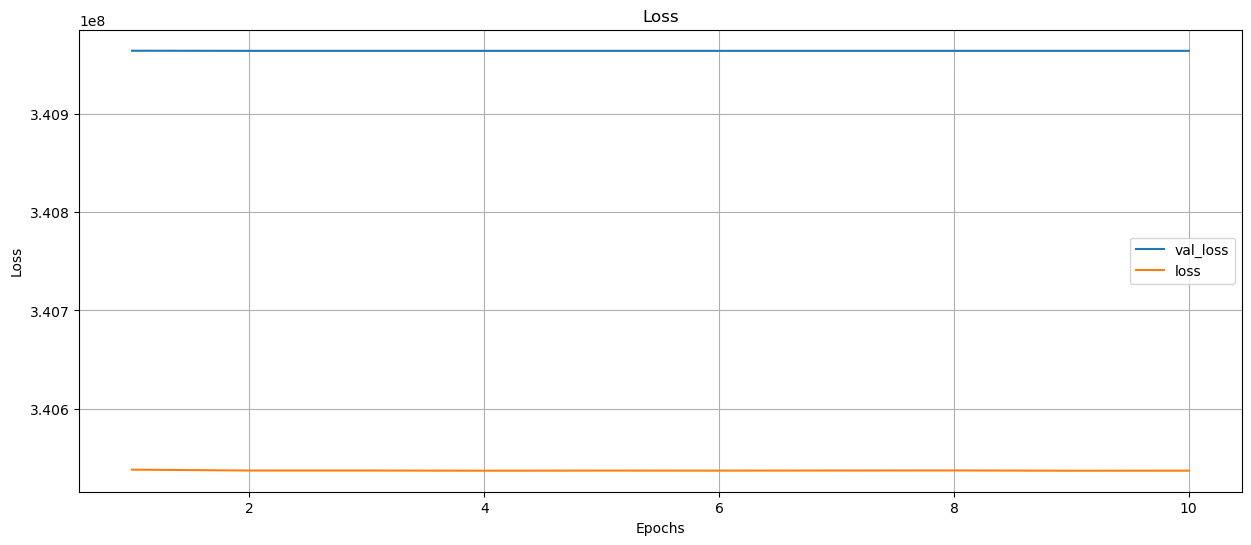

In [83]:
#Affichage de la précison de la perte selon l'epoch
epochs=range(1,len(history.history['val_loss'])+1)
plt.figure(figsize=(15,6))
#plt.subplot(121)
plt.title('Loss')
plt.plot(epochs,history.history['val_loss'],label='val_loss')
plt.plot(epochs,history.history['loss'],label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0.5,1.5])
plt.grid()
plt.legend()
plt.show()

In [84]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [93]:
#Modèle Convolutif:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(4, 4, 1)),
      layers.Conv2D(3, (3, 3), activation='relu', padding='same'),
      layers.Conv2D(2, (3, 3), activation='relu', padding='same')])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(2, kernel_size=3, activation='relu', padding='same'),
      layers.Conv2DTranspose(3, kernel_size=3, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [94]:
#Ajustement de la dimension pour l'AE convolutif
print(X0tr.shape)
co0=X0tr.reshape(X0tr.shape[0],4,4,1).astype('float32')#add an additional dimension to
co0te=X0te.reshape(X0te.shape[0],4,4,1).astype('float32')
print(co0.shape)

(10288, 16)
(10288, 4, 4, 1)


In [95]:
autoencoder2 = Denoise()
autoencoder2.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [96]:
history2=autoencoder2.fit(flow0, flow0,
                epochs=10,
                shuffle=True,
                validation_data=(flow0te, flow0te))
autoencoder2.summary()

Epoch 1/10
322/322 [==============================] - 1s 2ms/step - loss: 340537920.0000 - val_loss: 340965376.0000
Epoch 2/10
322/322 [==============================] - 0s 1ms/step - loss: 340538016.0000 - val_loss: 340965376.0000
Epoch 3/10
322/322 [==============================] - 0s 1ms/step - loss: 340538080.0000 - val_loss: 340964960.0000
Epoch 4/10
322/322 [==============================] - 0s 1ms/step - loss: 340537600.0000 - val_loss: 340964960.0000
Epoch 5/10
322/322 [==============================] - 0s 1ms/step - loss: 340537632.0000 - val_loss: 340964960.0000
Epoch 6/10
322/322 [==============================] - 0s 1ms/step - loss: 340537664.0000 - val_loss: 340964960.0000
Epoch 7/10
322/322 [==============================] - 0s 1ms/step - loss: 340537568.0000 - val_loss: 340964960.0000
Epoch 8/10
322/322 [==============================] - 0s 1ms/step - loss: 340537632.0000 - val_loss: 340964960.0000
Epoch 9/10
322/322 [==============================] - 0s 1ms/step - loss